In [18]:
using ElectricGrid
using PlotlyJS

In our Implementation we set up our ODE's as linear ODE's. But certainly the real components are nonlinear in most cases.
Thats why we added a way to describe the nonlinearity regarding the voltage and the current and solve it with any ODE'solvers from [DifferentialEquations](https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/). 

In the following I'm going to setup an easy Example which you can see in ... 
#todo Marvin

In [19]:
CM = [0. 1.
     -1. 0.]

S_source = 1e4
S_load = 1e2
pf_load = 1
v_rms = 230
R_load, L_load, X, Z = ParallelLoadImpedance(S_load, pf_load, v_rms);

As you will see, one linear and one nonlinear parameter dict is set up. And the nonlinear on just uses a constant function such that the Result should be comparable.
You can find it under the key cable and then L.

In [20]:
parameters_linear = Dict{Any, Any}(
    "source" => Any[
                    Dict{Any, Any}("pwr" => S_source, "control_type" => "classic", "mode" => "Swing", "fltr" => "LC", "i_limit" => 1e4, "v_limit" => 1e4,),
                    ],
    "load"   => Any[
                    Dict{Any, Any}("impedance" => "R", "R" => R_load, "v_limit" => 1e4, "i_limit" => 1e4)
                    ],
    "cable"   => Any[
                    Dict{Any, Any}("R" => 1e-3, "L" => 1e-4, "C" => 1e-4),
                    ],
    "grid" => Dict{Any, Any}("fs"=>1e4, "phase"=>3, "v_rms"=>230, "f_grid" => 50, "ramp_end"=>0.00)
)

env_linear = ElectricGridEnv(CM = CM, parameters = parameters_linear, verbosity = 2);

┌ Info: Normalization is done based on the defined parameter limits.
└ @ ElectricGrid /Users/benediktbrueck/Documents/GitHub/ElectricGrid.jl/src/electric_grid_env.jl:358
┌ Info: Time simulation run time: 0.0499 [s] ~> 500 steps
└ @ ElectricGrid /Users/benediktbrueck/Documents/GitHub/ElectricGrid.jl/src/electric_grid_env.jl:359


In [21]:
parameters_nonlinear = Dict{Any, Any}(
    "source" => Any[
                    Dict{Any, Any}("pwr" => S_source, "control_type" => "classic", "mode" => "Swing", "fltr" => "LC", "i_limit" => 1e4, "v_limit" => 1e4,),
                    ],
    "load"   => Any[
                    Dict{Any, Any}("impedance" => "R", "R" => R_load, "v_limit" => 1e4, "i_limit" => 1e4)
                    ],
    "cable"   => Any[
                    Dict{Any, Any}("R" => 1e-3, "L" => x->1e-4, "C" => 1e-4),
                    ],
    "grid" => Dict{Any, Any}("fs"=>1e4, "phase"=>3, "v_rms"=>230, "f_grid" => 50, "ramp_end"=>0.00)
)

env_nonlinear = ElectricGridEnv(CM = CM, parameters = parameters_nonlinear, t_end = 0.04, verbosity = 2, nonlinear_solver = SSPRK33());

┌ Info: Nonlinear Solver: Use SSPRK33 as solver.
└ @ ElectricGrid /Users/benediktbrueck/Documents/GitHub/ElectricGrid.jl/src/electric_grid_env.jl:165
┌ Info: Normalization is done based on the defined parameter limits.
└ @ ElectricGrid /Users/benediktbrueck/Documents/GitHub/ElectricGrid.jl/src/electric_grid_env.jl:358
┌ Info: Time simulation run time: 0.04 [s] ~> 401 steps
└ @ ElectricGrid /Users/benediktbrueck/Documents/GitHub/ElectricGrid.jl/src/electric_grid_env.jl:359


In [22]:
GetStateIds(env_linear.nc)

15-element Vector{String}:
 "source1_i_L1_a"
 "source1_v_C_filt_a"
 "source1_v_C_cables_a"
 "cable1_i_L_a"
 "load1_v_C_total_a"
 "source1_i_L1_b"
 "source1_v_C_filt_b"
 "source1_v_C_cables_b"
 "cable1_i_L_b"
 "load1_v_C_total_b"
 "source1_i_L1_c"
 "source1_v_C_filt_c"
 "source1_v_C_cables_c"
 "cable1_i_L_c"
 "load1_v_C_total_c"

As you can see in the list from above the 4th value in the list is a cable related thing. Thats why we choose it and compare it linearly and nonlinearly

In [23]:
value = 4

sol_linear = []
for i = 1:500
    env_linear([0.5, 0.5, 0.5])
    append!(sol_linear,env_linear.x[value])
end

In [ ]:
sol_nonlinear = []
for i = 1:500
    env_nonlinear([0.5, 0.5, 0.5])
    append!(sol_nonlinear,env_nonlinear.x[value])
end

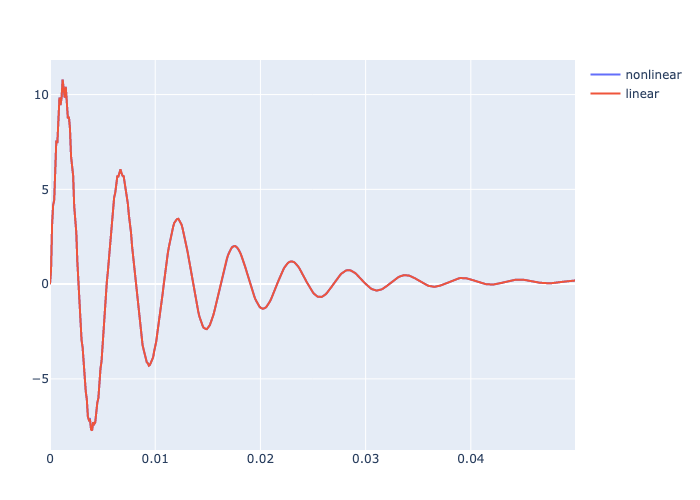

In [25]:
t_nonlinear = collect(env_nonlinear.t0:env_nonlinear.ts:env_nonlinear.t)
p_nonlinear = scatter(x=t_nonlinear,y=sol_nonlinear,mode="lines",name="nonlinear")

t_linear = collect(env_linear.t0:env_linear.ts:env_linear.t)
p_linear = scatter(x=t_linear,y=sol_linear,mode="lines",name="linear")

plot([p_nonlinear,p_linear])

Other orbitrary function...


In [26]:
function NonlinearInductance(value, drop, length)
    return x -> value*(1-drop/100) + value*(drop/100)*1/(1+exp(-(abs(x)-length/2)/2))
end

p = 80
l = NonlinearInductance(0.0001,p,600)

#13 (generic function with 1 method)